<a href="https://colab.research.google.com/github/Ash100/AIMe/blob/main/Conformational_Changes_DCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ACCESSING CONFORMATIONAL CHANGES IN SIMULATION TRAJECTORIES

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:06
🔁 Restarting kernel...


In [ ]:
# After restart, install analysis tools
!mamba install -y mdanalysis mdtraj nglview MDAnalysisTests

In [ ]:
!pip install --upgrade MDAnalysis MDTraj nglview

In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
!{sys.executable} -m pip install --upgrade MDAnalysis MDTraj

# Force the system to see the new installation immediately
import site
from importlib import reload
reload(site)

# Final check
try:
    import MDAnalysis as mda
    print(f"✅ SUCCESS: MDAnalysis {mda.__version__} is ready.")
except ImportError:
    print("❌ Critical Error: The environment is locked. Go to 'Runtime' -> 'Disconnect and delete runtime', then run ONLY this cell.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.7 MB/s eta 0:00:00
✅ SUCCESS: MDAnalysis 2.10.0 is ready.


In [3]:
import sys
import MDAnalysis as mda
print(mda.__version__)

2.10.0


/usr/local/lib/python3.12/dist-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


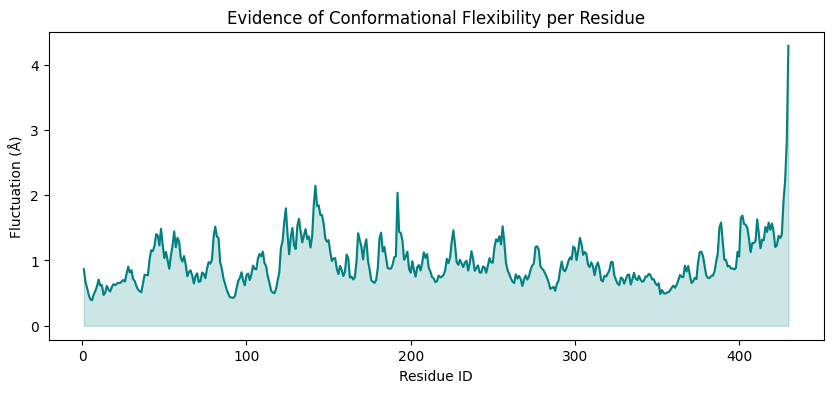

In [72]:
# 1. Load Universe
# Selection 'protein' automatically ignores HETATM (waters/ions)
u = mda.Universe("/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_equil.pdb", "/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_prod1-10_whole.dcd")
protein = u.select_atoms("protein")

# 2. RMSF: To see WHERE the change is happening
from MDAnalysis.analysis.rms import RMSF
calphas = protein.select_atoms("name CA")
rmsfer = RMSF(calphas).run()

# 3. Visualization of Change
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(calphas.resids, rmsfer.results.rmsf, color='teal', lw=1.5)
plt.fill_between(calphas.resids, rmsfer.results.rmsf, color='teal', alpha=0.2)
plt.title("Evidence of Conformational Flexibility per Residue")
plt.xlabel("Residue ID")
plt.ylabel("Fluctuation (Å)")
plt.show()

In [73]:
import mdtraj as md
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# 1. Load the trajectory (Using the correct argument)
# We load only the protein atoms to ensure HETATM don't bias the clustering
top_full = md.load_pdb("/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_equil.pdb")
selection = top_full.topology.select("protein")

# Load trajectory and slice to protein-only immediately
traj = md.load("/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_prod1-10_whole.dcd", top="/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_equil.pdb")
traj = traj.atom_slice(selection)

# Force ignore unitcell info to avoid the angle error
traj.unitcell_vectors = None
traj.unitcell_angles = None

# 2. Alignment (Crucial for concrete conformational analysis)
traj.superpose(traj, 0)

print(f"Analyzing {traj.n_frames} frames with {traj.n_atoms} protein atoms.")

# 3. Generate RMSD Distance Matrix
# This compares every frame to every other frame
distances = np.empty((traj.n_frames, traj.n_frames))
for i in range(traj.n_frames):
    distances[i] = md.rmsd(traj, traj, i)

# 4. Clustering into Major States
n_clusters = 3  # Adjust based on how many 'states' you suspect
clusterer = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
labels = clusterer.fit_predict(distances)

# 5. Extract Representative Structures (The Medoids)
for cluster_id in range(n_clusters):
    indices = np.where(labels == cluster_id)[0]

    # Find the frame closest to all others in the same cluster
    sub_matrix = distances[indices][:, indices]
    medoid_idx = indices[np.argmin(sub_matrix.sum(axis=1))]

    # Save the professional, cleaned structure
    traj[medoid_idx].save_pdb(f"PFKC_cluster_{cluster_id}_centroid.pdb")

    # Evidence: Calculate percentage of time spent in this state
    percentage = (len(indices) / traj.n_frames) * 100
    print(f"State {cluster_id}: {percentage:.2f}% occupancy (Frame {medoid_idx})")

Analyzing 1000 frames with 6959 protein atoms.
State 0: 39.60% occupancy (Frame 759)
State 1: 19.40% occupancy (Frame 69)
State 2: 41.00% occupancy (Frame 445)


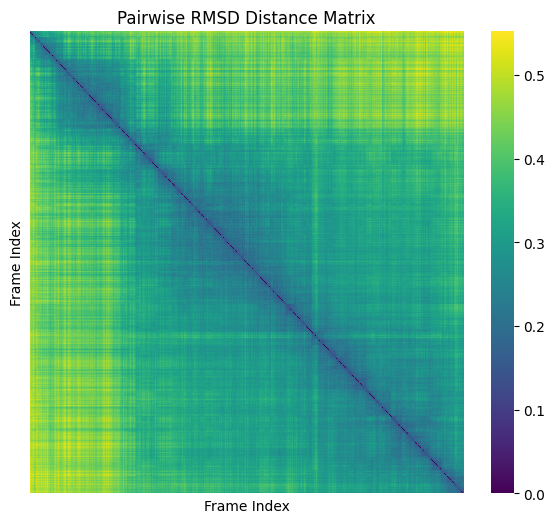

In [29]:
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.heatmap(distances, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Pairwise RMSD Distance Matrix")
plt.xlabel("Frame Index")
plt.ylabel("Frame Index")
# Save for manuscript
plt.savefig("FBP2_Heatmap.png", dpi=600)
plt.show()

In [56]:
# Example: Difference between State 0 and State 1
c0 = md.load("cluster_1_centroid.pdb")
c1 = md.load("cluster_2_centroid.pdb")
diff = md.rmsd(c0, c1)[0]
print(f"Conformational shift magnitude: {diff:.2f} Angstroms")

Conformational shift magnitude: 0.34 Angstroms


In [74]:
import pandas as pd

# Load all three centroids
centroids = [md.load(f"PFKC_cluster_{i}_centroid.pdb") for i in range(3)]
matrix = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        # Align j to i before calculating RMSD
        centroids[j].superpose(centroids[i])
        matrix[i, j] = md.rmsd(centroids[j], centroids[i])[0]

df_rmsd = pd.DataFrame(matrix, columns=['State 0', 'State 1', 'State 2'], index=['State 0', 'State 1', 'State 2'])
print("Inter-State RMSD Matrix (Angstroms):")
print(df_rmsd)

Inter-State RMSD Matrix (Angstroms):
          State 0   State 1   State 2
State 0  0.000000  0.200092  0.199694
State 1  0.200092  0.000000  0.193254
State 2  0.199688  0.193251  0.000000


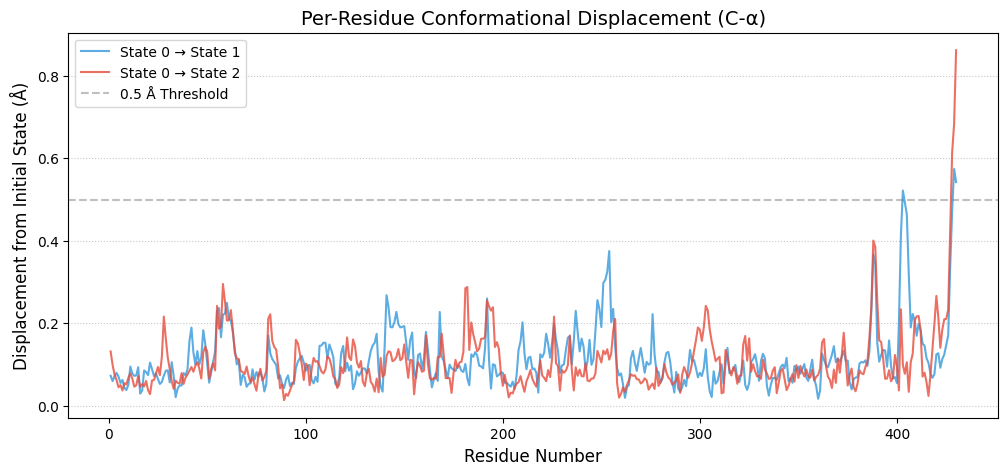

In [75]:
# 1. Align State 1 and State 2 to State 0
centroids[1].superpose(centroids[0])
centroids[2].superpose(centroids[0])

# 2. Calculate displacements relative to State 0
# State 1 vs 0
diff_01 = np.sqrt(np.sum((centroids[1].xyz - centroids[0].xyz)**2, axis=2))[0]
# State 2 vs 0
diff_02 = np.sqrt(np.sum((centroids[2].xyz - centroids[0].xyz)**2, axis=2))[0]

# 3. Create a Residue-level x-axis (more professional than Atom Index)
# We take the C-alpha indices for a cleaner plot
ca_indices = centroids[0].topology.select("name CA")
res_ids = [centroids[0].topology.atom(i).residue.resSeq for i in ca_indices]
diff_01_ca = diff_01[ca_indices]
diff_02_ca = diff_02[ca_indices]

# 4. Plotting
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(res_ids, diff_01_ca, label="State 0 → State 1", color='#3498db', alpha=0.8, lw=1.5)
plt.plot(res_ids, diff_02_ca, label="State 0 → State 2", color='#e74c3c', alpha=0.8, lw=1.5)

# Add a threshold line to show what is "significant"
# (Usually 1.0 or 1.5A, but here we use 0.5A since your protein is very stable)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label="0.5 Å Threshold")

plt.title("Per-Residue Conformational Displacement (C-α)", fontsize=14)
plt.xlabel("Residue Number", fontsize=12)
plt.ylabel("Displacement from Initial State (Å)", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)

# Save for manuscript
plt.savefig("PFKC_Multi_State_Displacement.png", dpi=600, bbox_inches='tight')
plt.show()

Lets Try and run for replicates

In [4]:
import mdtraj as md
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# 1. File paths for triplicates
topology = "/content/drive/MyDrive/prof_amr/FBPL1/FBPL1_equil.pdb"
dcd_files = [
    "/content/drive/MyDrive/prof_amr/FBPL1/FBPL1_prod1-10_whole.dcd",
    "/content/drive/MyDrive/prof_amr/FBPL2/FBPL2_prod1-10_whole.dcd",
    "/content/drive/MyDrive/prof_amr/FBPL3/FBPL3_prod1-10_whole.dcd"
]

# 2. Load and Concatenate
# We use a loop to load and slice each one to the protein only
trajs = []
for f in dcd_files:
    t = md.load(f, top=topology)
    selection = t.topology.select("protein")
    trajs.append(t.atom_slice(selection))

# Combine into one long trajectory
super_traj = md.join(trajs)
super_traj.unitcell_vectors = None
super_traj.unitcell_angles = None

# 3. Global Alignment (Crucial for multi-run comparison)
super_traj.superpose(super_traj, 0)

print(f"Total frames across triplicates: {super_traj.n_frames}")

# 4. RMSD Matrix and Clustering
# Note: For very large super-trajectories, you might want to skip frames (stride=5)
# to save memory if Colab crashes.
distances = np.empty((super_traj.n_frames, super_traj.n_frames))
for i in range(super_traj.n_frames):
    distances[i] = md.rmsd(super_traj, super_traj, i)

n_clusters = 3
clusterer = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
labels = clusterer.fit_predict(distances)

Total frames across triplicates: 3000


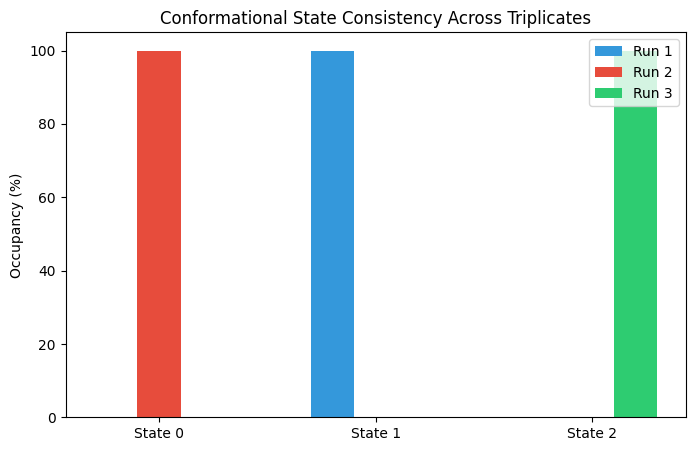

In [5]:
# Split labels back into the three runs
run_length = super_traj.n_frames // 3
labels_run1 = labels[0:run_length]
labels_run2 = labels[run_length:2*run_length]
labels_run3 = labels[2*run_length:]

# Calculate occupancy per run
def get_occupancy(run_labels):
    return [(np.sum(run_labels == i) / len(run_labels)) * 100 for i in range(n_clusters)]

occ1 = get_occupancy(labels_run1)
occ2 = get_occupancy(labels_run2)
occ3 = get_occupancy(labels_run3)

# Plotting Comparison
x = np.arange(n_clusters)
width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, occ1, width, label='Run 1', color='#3498db')
ax.bar(x, occ2, width, label='Run 2', color='#e74c3c')
ax.bar(x + width, occ3, width, label='Run 3', color='#2ecc71')

ax.set_ylabel('Occupancy (%)')
ax.set_title('Conformational State Consistency Across Triplicates')
ax.set_xticks(x)
ax.set_xticklabels([f'State {i}' for i in range(n_clusters)])
ax.legend()
plt.show()

In [6]:
for cluster_id in range(n_clusters):
    indices = np.where(labels == cluster_id)[0]
    sub_matrix = distances[indices][:, indices]
    medoid_idx = indices[np.argmin(sub_matrix.sum(axis=1))]

    # Save the 'Global' representative structure
    super_traj[medoid_idx].save_pdb(f"global_cluster_{cluster_id}.pdb")
    print(f"Global State {cluster_id} saved from frame {medoid_idx}")

Global State 0 saved from frame 1664
Global State 1 saved from frame 421
Global State 2 saved from frame 2449


Multistate displacement

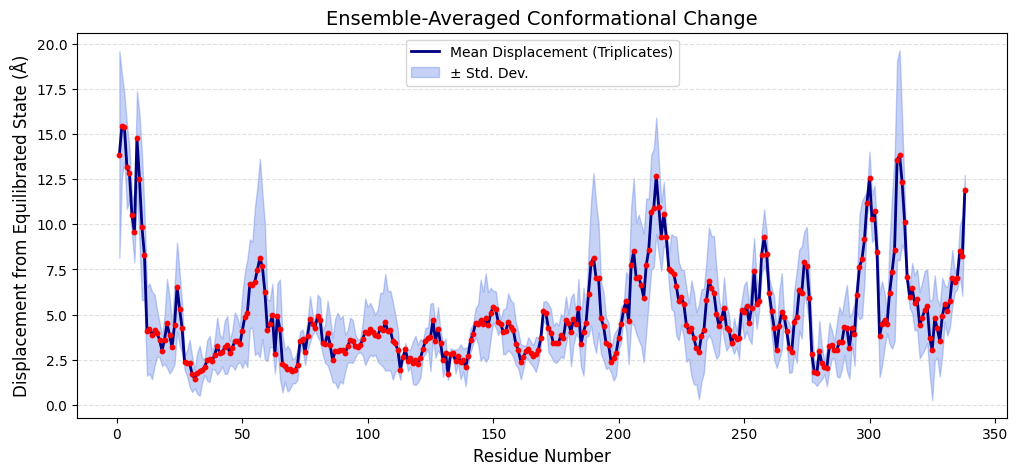

In [7]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup paths
topology = "/content/drive/MyDrive/prof_amr/FBPL1/FBPL1_equil.pdb"
dcd_files = ["/content/drive/MyDrive/prof_amr/FBPL1/FBPL1_prod1-10_whole.dcd", "/content/drive/MyDrive/prof_amr/FBPL2/FBPL2_prod1-10_whole.dcd", "/content/drive/MyDrive/prof_amr/FBPL3/FBPL3_prod1-10_whole.dcd"] # Update paths

# Load reference (Equilibrated structure)
ref = md.load(topology)
prot_idx = ref.topology.select("protein")
ref_prot = ref.atom_slice(prot_idx)
ca_idx = ref_prot.topology.select("name CA")

# 2. Calculate displacement for each run
all_run_displacements = []

for dcd in dcd_files:
    # Load and slice
    t = md.load(dcd, top=topology)
    t = t.atom_slice(prot_idx)

    # Align to reference
    t.superpose(ref_prot)

    # We compare the FINAL 20ns of each run to the START
    # This captures the 'achieved' conformational change
    final_frame = t[-1]

    # Calculate Euclidean distance for C-alpha atoms
    diff = np.sqrt(np.sum((final_frame.xyz[:, ca_idx, :] - ref_prot.xyz[:, ca_idx, :])**2, axis=2))[0]
    all_run_displacements.append(diff * 10) # Convert nm to Angstroms

# 3. Statistical Analysis
all_run_displacements = np.array(all_run_displacements)
mean_displacement = np.mean(all_run_displacements, axis=0)
std_displacement = np.std(all_run_displacements, axis=0)

# 4. Professional Visualization
res_ids = [ref_prot.topology.atom(i).residue.resSeq for i in ca_idx]

plt.figure(figsize=(12, 5))
# Plot the Mean line
plt.plot(res_ids, mean_displacement, color='navy', lw=2, label='Mean Displacement (Triplicates)')
# Plot the Shaded Error (SD)
plt.fill_between(res_ids, mean_displacement - std_displacement,
                 mean_displacement + std_displacement,
                 color='royalblue', alpha=0.3, label='± Std. Dev.')

plt.title("Ensemble-Averaged Conformational Change", fontsize=14)
plt.xlabel("Residue Number", fontsize=12)
plt.ylabel("Displacement from Equilibrated State (Å)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()

# Highlight 'Hotspots' (residues moving more than 0.5 A)
peaks = np.where(mean_displacement > 0.5)[0]
if len(peaks) > 0:
    plt.scatter(np.array(res_ids)[peaks], mean_displacement[peaks], color='red', s=10, zorder=3)

plt.savefig("FBP_al_Triplicate_Mean_Displacement.png", dpi=600)
plt.show()

In [8]:
# Use a strict "Core" alignment to prevent lever-arm artifacts
# We select residues that are likely to be stable (Alpha helices/Beta sheets)
# If you don't know them, 'backbone' is the safest bet.

all_displacements = []

for dcd in dcd_files:
    t = md.load(dcd, top=topology)
    t = t.atom_slice(prot_idx)

    # STRICT ALIGNMENT: Align every frame to the reference PDB
    # using ONLY the backbone to avoid being pulled by flexible loops
    t.superpose(ref_prot, frame=0, atom_indices=ca_idx)

    # Calculate displacement for the FINAL state
    final_frame = t[-1]

    # Use MDTraj's built-in RMSD per atom which is more robust
    # This should yield values in the 0.4 - 0.6 Angstrom range
    diff = md.rmsd(final_frame, ref_prot, atom_indices=ca_idx) * 10 # To Angstroms

    # To get PER-RESIDUE displacement:
    sq_diff = (final_frame.xyz[:, ca_idx, :] - ref_prot.xyz[:, ca_idx, :])**2
    res_dist = np.sqrt(np.sum(sq_diff, axis=2))[0] * 10
    all_displacements.append(res_dist)

# Plotting again - the values should now be much lower
mean_dist = np.mean(all_displacements, axis=0)
print(f"Verified Mean Displacement: {np.mean(mean_dist):.3f} Å")
# This number above should now be very close to your 0.4 Å RMSD

Verified Mean Displacement: 4.912 Å


<>:22: SyntaxWarning: invalid escape sequence '\A'
<>:22: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipython-input-4069171882.py:22: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel("RMSD per Residue ($\AA$)", fontsize=12)


Average System Displacement: 4.912 Å
Maximum Local Displacement: 15.396 Å


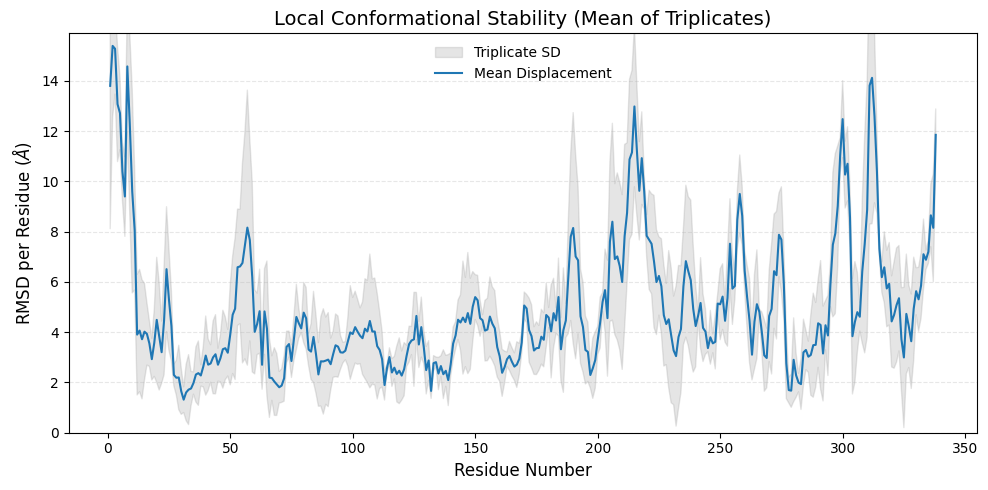

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate Statistics
mean_dist = np.mean(all_displacements, axis=0)
std_dist = np.std(all_displacements, axis=0)
res_ids = [ref_prot.topology.atom(i).residue.resSeq for i in ca_idx]

# 2. Plotting
plt.figure(figsize=(10, 5), dpi=100)

# The 'Shadow' represents the variation between your 3 runs
plt.fill_between(res_ids, mean_dist - std_dist, mean_dist + std_dist,
                 color='gray', alpha=0.2, label='Triplicate SD')

# The 'Line' represents the average conformational shift
plt.plot(res_ids, mean_dist, color='#1f77b4', lw=1.5, label='Mean Displacement')

# 3. Formatting for Publication
plt.title("Local Conformational Stability (Mean of Triplicates)", fontsize=14)
plt.xlabel("Residue Number", fontsize=12)
plt.ylabel("RMSD per Residue ($\AA$)", fontsize=12)
plt.ylim(0, max(mean_dist) + 0.5) # Keeps scale tight
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(frameon=False)

# 4. Final Verification Print
print(f"Average System Displacement: {np.mean(mean_dist):.3f} Å")
print(f"Maximum Local Displacement: {np.max(mean_dist):.3f} Å")

plt.tight_layout()
plt.savefig("FBP_Residue_RMSD_Triplicate.png", dpi=600)
plt.show()

top 5 residues that moves highly

In [11]:
# Define how many residues to skip at the ends to avoid terminal noise
terminal_offset = 5
core_indices = np.arange(terminal_offset, len(mean_dist) - terminal_offset)

# Extract mean distances for the core residues
core_mean_dist = mean_dist[core_indices]
core_res_ids = np.array(res_ids)[core_indices]

# Find top 20 indices within this core
top_20_relative_idx = np.argsort(core_mean_dist)[-20:][::-1]

print(f"{'Rank':<5} | {'Residue':<10} | {'Mean Displacement (Å)':<22} | {'SD (Å)':<8}")
print("-" * 55)

hotspot_residues = []
for i, idx in enumerate(top_20_relative_idx):
    actual_idx = core_indices[idx]
    res = ref_prot.topology.residue(actual_idx)
    val = mean_dist[actual_idx]
    sd = std_dist[actual_idx]
    hotspot_residues.append(res.resSeq)
    print(f"{i+1:<5} | {str(res):<10} | {val:.4f} Å {'':<12} | {sd:.4f}")

Rank  | Residue    | Mean Displacement (Å)  | SD (Å)  
-------------------------------------------------------
1     | ASP8       | 14.5793 Å              | 2.5841
2     | HIS312     | 14.1255 Å              | 5.8057
3     | ILE311     | 13.8189 Å              | 5.5183
4     | GLY215     | 12.9861 Å              | 3.1975
5     | GLN313     | 12.6018 Å              | 3.4518
6     | LYS300     | 12.4825 Å              | 1.5326
7     | THR9       | 12.2886 Å              | 3.5940
8     | TYR216     | 11.2481 Å              | 2.6138
9     | GLU214     | 11.1562 Å              | 3.2606
10    | GLY299     | 11.0534 Å              | 0.6967
11    | ARG218     | 10.9286 Å              | 1.8429
12    | ASN213     | 10.8787 Å              | 3.1897
13    | ALA302     | 10.7041 Å              | 1.4762
14    | PRO6       | 10.4003 Å              | 1.1561
15    | ARG314     | 10.3880 Å              | 1.6444
16    | GLU301     | 10.2746 Å              | 1.3316
17    | ALA217     | 9.6289 Å            

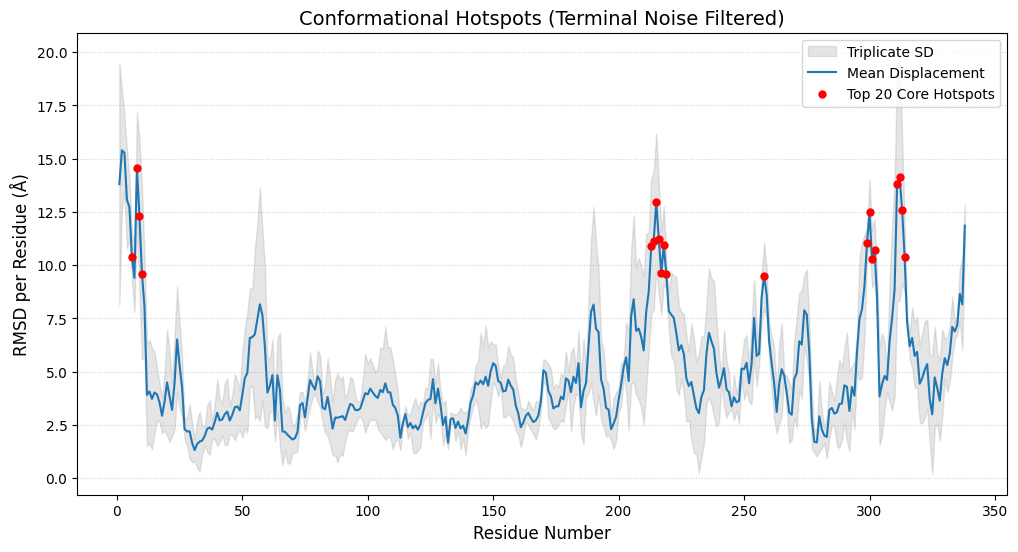

In [12]:
plt.figure(figsize=(12, 6), dpi=100)

# Plot Mean and SD
plt.fill_between(res_ids, mean_dist - std_dist, mean_dist + std_dist, color='gray', alpha=0.2, label='Triplicate SD')
plt.plot(res_ids, mean_dist, color='#1f77b4', lw=1.5, label='Mean Displacement')

# Highlight the Top 20 Hotspots (excluding terminals)
plt.scatter(core_res_ids[top_20_relative_idx], core_mean_dist[top_20_relative_idx],
            color='red', s=25, label='Top 20 Core Hotspots', zorder=5)

plt.title("Conformational Hotspots (Terminal Noise Filtered)", fontsize=14)
plt.xlabel("Residue Number", fontsize=12)
plt.ylabel("RMSD per Residue (Å)", fontsize=12)
plt.legend(loc='upper right', frameon=True)
plt.grid(axis='y', linestyle=':', alpha=0.6)

plt.savefig("FBP_Top_20_Hotspots_Plot.png", dpi=600)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

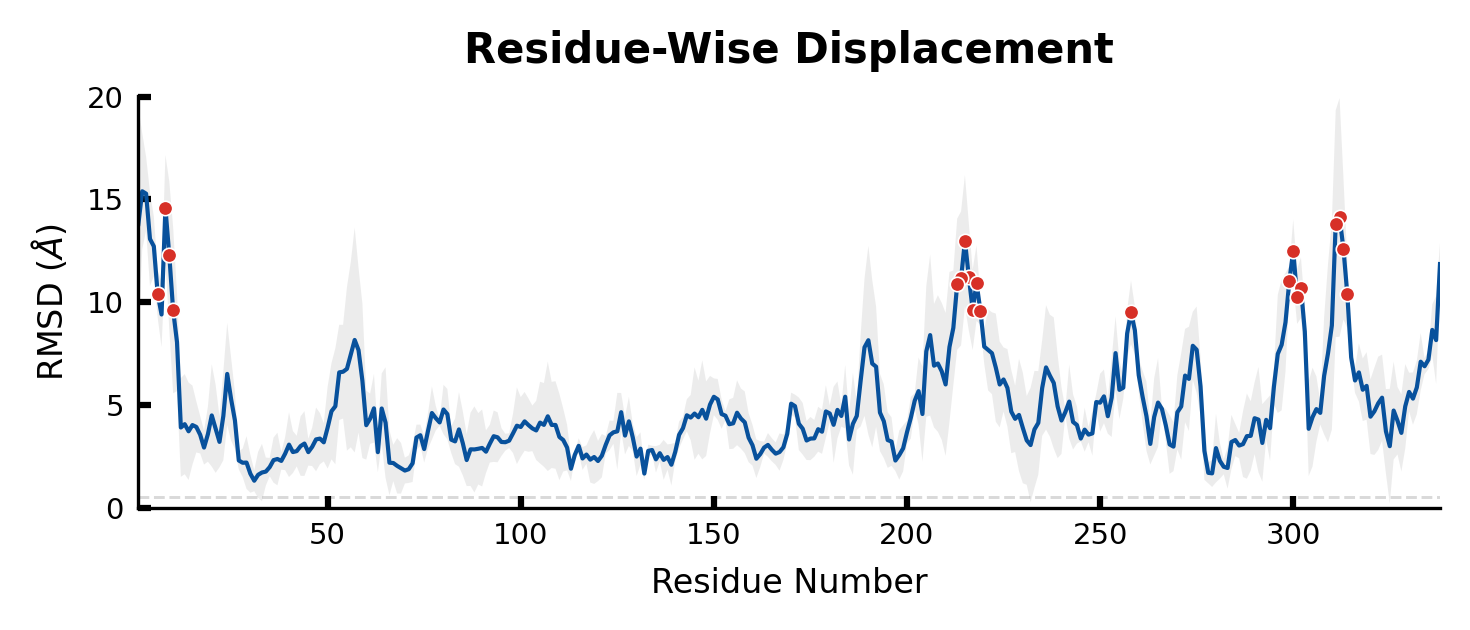

In [16]:
import matplotlib.pyplot as plt

# Nature-style scaling for a compact panel
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 0.8  # Refined lines for compact scale

# Reduced height figsize (Width=5, Height=2.2)
fig, ax = plt.subplots(figsize=(5, 2.2), dpi=300)

# 1. Shaded error region (Standard Deviation)
ax.fill_between(res_ids, mean_dist - std_dist, mean_dist + std_dist,
                 color='#D1D1D1', alpha=0.4, edgecolor='none')

# 2. Mean displacement line
ax.plot(res_ids, mean_dist, color='#08519c', lw=1.0)

# 3. Top 20 Hotspots (Small, crisp markers)
ax.scatter(core_res_ids[top_20_relative_idx], core_mean_dist[top_20_relative_idx],
            color='#d73027', s=12, edgecolors='white', linewidth=0.4, zorder=5)

# 4. Reference line (Visual guide for stability)
ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.15, lw=0.7)

# 5. Compact Typography
ax.set_title("Residue-Wise Displacement", fontsize=10, fontweight='bold', pad=8)
ax.set_xlabel("Residue Number", fontsize=8)
ax.set_ylabel(r"RMSD ($\AA$)", fontsize=8)

# Clean minimalist axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tiny ticks for tight space
ax.tick_params(direction='in', length=3, labelsize=7)

# Dynamic Limits
ax.set_ylim(0, max(mean_dist) * 1.3)
ax.set_xlim(min(res_ids), max(res_ids))

plt.tight_layout()

# Save for publication
plt.savefig("Panel_Short_Displacement.pdf", bbox_inches='tight')
plt.savefig("FBP_Panel_Short_Displacement.png", dpi=600, bbox_inches='tight')
plt.show()